In [1]:
from collections import defaultdict
import pickle
import glob
import warnings
warnings.filterwarnings('ignore')

from tools.text_process import SimpleLemmaTokenizer
from tools.instance import Node
from tools.containers import LayerName, Picture, Description
from tools.knowledge import LayerBase, TextBase
# from tools.common import ravel

# from models.encoder import TextPictureRavelHistSimiEncoder
from models.dataset import Dataset
from tools.common import getBase

Decoration..


In [2]:
# layerbase = LayerBase()
# textbase = TextBase()

# print(len(layerbase.vocab_))
# print(type(layerbase.vocab_))
# print(type(layerbase.vocab_[0]))
# print(layerbase.vocab_[0].count)

# print('----------')
# print(len(textbase.vocab_))#index('man','n')
# print(type(textbase.vocab_))
# print(type(textbase.vocab_[0]))
# print(dir(textbase.vocab_[0]))
# print(textbase.vocab_[0].count)
# # textbase.vocab_

In [3]:
# img_dir='images'
# txt_dir='text'
# name = 'Firmware'

# description = Description('%s/%s.txt' % (txt_dir, name))
# picture = Picture('%s/%s.svg' % (img_dir, name))
# print(picture)
# print(description)

# encoder = TextPictureRavelHistSimiEncoder()
# vec = encoder.encode(description, picture)#.toarray()
# vec.shape

In [4]:
import re
import random
from sklearn.linear_model import LogisticRegression
from ana.visual import STAT, ROC, FEAT
random.seed(7)
np.random.seed(7)

from models.generator import exhaustivePicGenerator
from scipy import sparse

class Pipeline:
    def __init__(self, beam={'background': 2,
                             'surrounding': 20,
                             'character': 20,
                             'accessory': 2}):
        self.beam = beam
        
        print(' ------ train test split -------')
        self.train_names, self.test_names = self.train_test_split()
        # assert('Frozen' in self.train_names)
        
        print(' ------ build dataset -------')
        self.dataset = Dataset(names=self.train_names)
        
        print(' ------ gather data -------')
        
        # self.train_set, self.test_set = 
        self.build_data(self.train_names,self.test_names)
        
        print(' ------ train and evaluation -------')
        self.clf = self.train(self.train_set)
        self.evaluate(self.clf, self.train_set, self.test_set)
    
#     def train_test_split(self, test_r=0.2, shuffle=True):
#         names = [getBase(path) for path in glob.glob('images/*.svg')]
#         names_ = [getBase(path) for path in glob.glob('text/*.txt')]
        
#         # names must be unique
#         assert(len(names) == len(set(names)))
#         # names from both sides must be identical
#         assert(set(names) == set(names_))
        
#         if shuffle:
#             random.shuffle(names)
        
#         ind = int(len(names) * (1-test_r))
        
#         return names[:ind], names[ind:]
    
    def train_test_split(self, test_r=0.2, shuffle=True):
        """
        use fixed train and test set
        """
        train = [getBase(path) for path in glob.glob('images_train/*.svg')]
        test = [getBase(path) for path in glob.glob('images_val/*.svg')]
        
        return train, test
    
    def __fetch_data(self, names):
        data = []
        pairs = []
        for c, name in enumerate(names):
            print('    Fetching: [%i] - %s' % (c, name), end='\r')
            vec, pair = self.dataset[name]
            data.append(vec)
            pairs.extend(pair)
        print('     Fetched: [%i]' % (c+1))
        data = sparse.vstack(data)
        return data, pairs
    
    def build_data(self, train, test):
#         train_set = []
#         train_pairs = []
#         for name in train:
#             print('     ------ Fetching [%s]' % name,
#                   end='\r')
#             vec, pair = self.dataset[name]
#             train_set.append(vec)
#             train_pairs.append(pair)
        
        print(' -------------- train set ---------------- ')
        self.train_set, self.train_pairs = self.__fetch_data(train) # np.vstack(train_set)
        
        print(' -------------- test set ---------------- ')
        # test_set = np.vstack([self.dataset[name] for name in test])
        self.test_set, self.test_pairs = self.__fetch_data(test)
        # return train_set, test_set
        # return None, None
    
    def train(self, train_set, class_weight={1: 1, 0: 0.1}, C=1.0):
        clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         class_weight=class_weight,
                         penalty='l1',
                         C=C,
                         max_iter=100)

        clf.fit(train_set[:,:-1],
                train_set[:,-1].toarray().flatten())
        return clf

    def evaluate(self, clf, train_set, test_set, 
                 save=False, suffix='temp'):
        print('------- train ---------')
        y_true = train_set[:,-1].toarray().flatten()
        y_prob = clf.predict_proba(train_set[:,:-1])[:,1]
        STAT(y_true, y_prob, save=save)

        print('------- test ---------')
        y_true = test_set[:,-1].toarray().flatten()
        y_prob = clf.predict_proba(test_set[:,:-1])[:,1]
        
        print('-- visual --')
        STAT(y_true, y_prob, save=save)
        ROC(y_true, y_prob, save=save)
        FEAT(self.dataset, clf, save=save, top=20)

    def predict(self, text, verbose=False):
        
        doc = Description(text=text)
        probas = []
        for i, pic in enumerate(exhaustivePicGenerator(self.dataset.encoder.layerbase, beam=self.beam, verbose=verbose)):
            vec = self.dataset.encoder.encode(doc, pic)
            probas.append((pic, self.clf.predict_proba([vec])[0,1]))
            # if i > 10: break
        # print(probas)
        return sorted(probas, key=lambda x: x[1])[-1][0]

In [5]:
### it's ok to have layerbase cover all the pictures
### because pictures are made from our layer base anyway
### not like text can type arbitraily

### 1.0: categories are fixed, thus no way there's an unseen category

 ------ train test split -------
 ------ build dataset -------
 - Initialize encoder..
Loading related dict..
 - Initiate layer base..
doneimages/product_teardown.svg] 

 - Initiate text base..
donetext/product_teardown.txt]]

 - Initiate scaler..
 - List feature names..
 ------ gather data -------
 -------------- train set ---------------- 
     Fetched: [70] - product_teardowng
 -------------- test set ---------------- 
     Fetched: [20] - pure_loveng_process
 ------ train and evaluation -------
------- train ---------
70 positives out of 210 test examples
Overall accuracy: 0.542857
*Recall(thresh=0.5)/AccuracyOf1: 1.000000
Precision(thresh=0.5): 0.421687
AccuracyOf0(thresh=0.5): 0.542857
------- test ---------
-- visual --
20 positives out of 60 test examples
Overall accuracy: 0.516667
*Recall(thresh=0.5)/AccuracyOf1: 0.950000
Precision(thresh=0.5): 0.404255
AccuracyOf0(thresh=0.5): 0.516667
precision | recall | F1 | threshold
------------------------------
0.408 | 1.000 | 0.580 | 

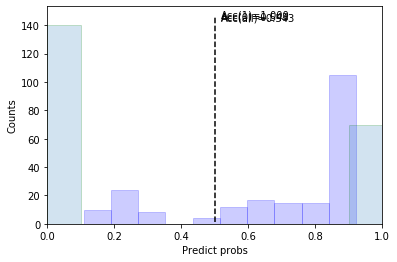

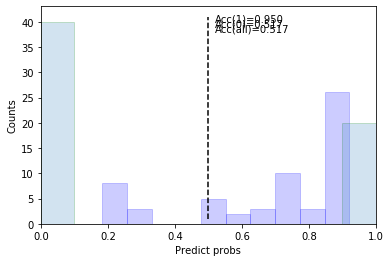

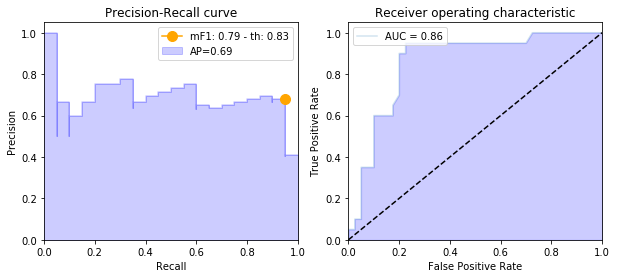

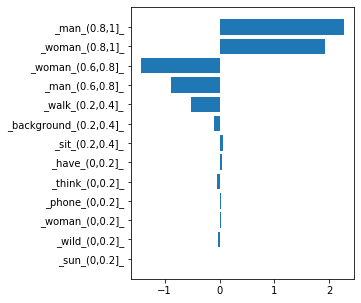

In [6]:
pipeline = Pipeline()

In [7]:
## please restart and check this again - later
## seems w/o bg not working

In [8]:
from models.metric import WeightedMeanIOU
metric = WeightedMeanIOU()

def avg_list_of_dict(ld):
    keys = ld[0].keys()
    avg_ = {}
    for key in keys:
        avg_[key] = sum([d[key] for d in ld]) / len(ld)
    return avg_

simis = []
for name in [getBase(path) for path in glob.glob('text_val/*.txt')]:
    print(' -------------------------- ')
    print(name)
    doc = Description('text_val/%s.txt' % name)
    print(doc)
    true_pic = Picture('images_val/%s.svg' % name)
    gen_pic = pipeline.predict(doc.text_)
    # gen_pic = random_gen(translate)
    print(true_pic)
    print(gen_pic)
    simi = metric.picture_simi(true_pic, gen_pic, with_bg=False)
    print(simi)
    simis.append(simi)
# print(sum(simis)/len(simis))
test_simi_dict = avg_list_of_dict(simis)
# print(avg_list_of_dict(simis))

Decoration..
Loading related dict..
 -------------------------- 
texting
A woman is standing by a tree with a mobile phone.

#background; #other(have[tree,message]); #woman(stand,hold[phone])
#office(have[draw,plant,cloth,hanger]); #woman(sit,hold[phone]); #accessory(have[dot])
[#other(have[tree,message]), #woman(stand,hold[phone])]
[#office(have[draw,plant,cloth,hanger]), #woman(sit,hold[phone]), #accessory(have[dot])]
{'subj': 0.3333333333333333, 'act': 0.5785, 'obj': 0.3333333333333333, 'overall': 0.3823666666666667}
 -------------------------- 
weather
A man is standing to give the weather report.

#background; #accessory(have[plant]); #other(have[bulletin]); #man(stand,point_to)
#chart(have[money,arrow]); #man(run); #accessory(have[leaf,rock])
[#accessory(have[plant]), #other(have[bulletin]), #man(stand,point_to)]
[#chart(have[money,arrow]), #man(run), #accessory(have[leaf,rock])]
{'subj': 0.6666666666666666, 'act': 0.6666666666666666, 'obj': 0.0, 'overall': 0.4666666666666666}
 -

A man is sitting in front of the leaves, and a woman is standing.

#background; #wild(have[leaf,sun,ground]); #man(sit); #woman(stand)
#chart(have[phone]); #group(have[woman(hug),man(hug)]); #accessory(have[guardrail])
[#wild(have[leaf,sun,ground]), #man(sit), #woman(stand)]
[#chart(have[phone]), #group(have[woman(hug),man(hug)]), #accessory(have[guardrail])]
{'subj': 0.125, 'act': 0.25, 'obj': 0.0, 'overall': 0.1125}
 -------------------------- 
prototyping_process
A woman is standing in front of the drawing board with a pen.

#background; #accessory(have[leaf]); #chart(have[pad,diagram]); #other(have[drawing_board]); #woman(stand,hold[pen])
#other(have[sun,cloud]); #woman(sit,hold[phone],watch[computer]); #accessory(have[leaf])
[#accessory(have[leaf]), #chart(have[pad,diagram]), #other(have[drawing_board]), #woman(stand,hold[pen])]
[#other(have[sun,cloud]), #woman(sit,hold[phone],watch[computer]), #accessory(have[leaf])]
{'subj': 0.75, 'act': 0.6225833333333334, 'obj': 0.25, 'overall

In [13]:
li = [0.2424986507936508, 0.2558924722222222, 0.29924813888888885]
sum(li)/len(li)

0.265879753968254

In [9]:
simis = []
for name in [getBase(path) for path in glob.glob('text_train/*.txt')]:
    print(' -------------------------- ')
    print(name)
    doc = Description('text_train/%s.txt' % name)
    print(doc)
    true_pic = Picture('images_train/%s.svg' % name)
    gen_pic = pipeline.predict(doc.text_)
    # gen_pic = random_gen(translate)
    print(true_pic)
    print(gen_pic)
    simi = metric.picture_simi(true_pic, gen_pic, with_bg=False)
    print(simi)
    simis.append(simi)
    
train_simi_dict = avg_list_of_dict(simis)
# print(sum(simis)/len(simis))

 -------------------------- 
road_sign
A man is standing in front of trees and signs.

#wild(have[tree,sign,sun]); #man(stand)
#other(have[sun,cloud]); #man(touch,stand); #accessory(have[leaf,rock])
[#wild(have[tree,sign,sun]), #man(stand)]
[#other(have[sun,cloud]), #man(touch,stand), #accessory(have[leaf,rock])]
{'subj': 0.3333333333333333, 'act': 0.5, 'obj': 0.08333333333333333, 'overall': 0.2916666666666667}
 -------------------------- 
printing_invoices
A man is sitting on a printer looking at his phone. A man and a woman are bending over to file.

#background; #accessory(have[leaf]); #other(have[printer]); #man(lift); #woman(lift); #man(sit,hold[phone])
#home(have[house,sun,tree]); #man(lift); #accessory(have[sign,leaf])
[#accessory(have[leaf]), #other(have[printer]), #man(lift), #woman(lift), #man(sit,hold[phone])]
[#home(have[house,sun,tree]), #man(lift), #accessory(have[sign,leaf])]
{'subj': 0.4, 'act': 0.6, 'obj': 0.1, 'overall': 0.35}
 -------------------------- 
projections


A woman is standing in front of a computer pad mobile phone.

#chart(have[computer]); #chart(have[pad]); #chart(have[phone]); #wild(have[tree]); #woman(stand,hold[computer])
#other(have[sun,cloud]); #woman(sit,hold[phone],watch[computer]); #accessory
[#chart(have[computer]), #chart(have[pad]), #chart(have[phone]), #wild(have[tree]), #woman(stand,hold[computer])]
[#other(have[sun,cloud]), #woman(sit,hold[phone],watch[computer]), #accessory]
{'subj': 0.16666666666666666, 'act': 0.24838888888888888, 'obj': 0.08333333333333333, 'overall': 0.1580111111111111}
 -------------------------- 
winter_designer
A woman is sitting on a chair in the office.

#background; #office(have[draw,plant,cloth,hanger]); #woman(sit_on[chair])
#chart(have[phone]); #woman(sit,hold[flower]); #accessory
[#office(have[draw,plant,cloth,hanger]), #woman(sit_on[chair])]
[#chart(have[phone]), #woman(sit,hold[flower]), #accessory]
{'subj': 0.3333333333333333, 'act': 0.42583333333333334, 'obj': 0.0, 'overall': 0.251833333

A woman holds a flower and sits on the grass.

#wild(have[plant]); #woman(sit,hold[flower])
#home(have[house,sun,tree]); #woman(sit,hold[phone],watch[computer]); #accessory(have[guardrail])
[#wild(have[plant]), #woman(sit,hold[flower])]
[#home(have[house,sun,tree]), #woman(sit,hold[phone],watch[computer]), #accessory(have[guardrail])]
{'subj': 0.3333333333333333, 'act': 0.5555555555555555, 'obj': 0.0, 'overall': 0.27777777777777773}
 -------------------------- 
product_hunt
A woman is standing next to the trophy and a cat.

#accessory(have[dot]); #other(have[dot,cup]); #woman(stand)
#home(have[sofa,toy,chips]); #woman(sit,hold[phone]); #accessory
[#accessory(have[dot]), #other(have[dot,cup]), #woman(stand)]
[#home(have[sofa,toy,chips]), #woman(sit,hold[phone]), #accessory]
{'subj': 0.6666666666666666, 'act': 0.41183333333333333, 'obj': 0.0, 'overall': 0.41569999999999996}
 -------------------------- 
Fish_bowl
A woman walk past a fish tank.

#wild(have[fish,plant,water,fish_tank,cloud]

A woman is running over hurdles.

#background; #woman(exercise,run_over[hurdle])
#home(have[house,sun,tree]); #woman(sit,hold[phone],watch[computer]); #accessory(have[guardrail])
[#woman(exercise,run_over[hurdle])]
[#home(have[house,sun,tree]), #woman(sit,hold[phone],watch[computer]), #accessory(have[guardrail])]
{'subj': 0.3333333333333333, 'act': 0.0, 'obj': 0.0, 'overall': 0.16666666666666666}
 -------------------------- 
virtual_reality
A man is lying watching a movie.

#background; #man(lie_on[sofa],watch[movie])
#background; #other(have[sun,cloud]); #man(sit,hold[phone]); #accessory(have[dot])
[#man(lie_on[sofa],watch[movie])]
[#other(have[sun,cloud]), #man(sit,hold[phone]), #accessory(have[dot])]
{'subj': 0.3333333333333333, 'act': 0.0, 'obj': 0.0, 'overall': 0.16666666666666666}
 -------------------------- 
portfolio_update
A woman is standing in front of the web page.

#accessory(have[circle,square]); #website(have[webpage]); #woman(stand)
#home(have[house,sun,tree]); #woman(s

In [15]:
print('& %.2f & %.2f & %.2f & %.2f & %.2f & %.2f & %.2f & %.2f & ' % (train_simi_dict['overall'], test_simi_dict['overall'],
 train_simi_dict['subj'], test_simi_dict['subj'],
 train_simi_dict['act'], test_simi_dict['act'],
 train_simi_dict['obj'], test_simi_dict['obj'],))

& 0.26 & 0.24 & 0.35 & 0.31 & 0.36 & 0.35 & 0.06 & 0.03 & 


In [24]:
sorted(list(pipeline.dataset.encoder.layerbase.layer_vocab_))[11].nested_entities_

{background(subj): {}}

In [6]:
pipeline.test_pairs

[(A woman is sitting on a chair in the office.,
  #background; #office(have[draw,plant,cloth,hanger]); #woman(sit_on[chair])),
 (A man was sitting on a bench holding a woman with three balloons.,
  #background; #office(have[draw,plant,cloth,hanger]); #woman(sit_on[chair])),
 (A woman is sitting on a chair in the office.,
  #background; #man(sit_on[chair],watch[computer])),
 (A man and two women are standing looking at the display board.,
  #background; #other(have[board,plant]); #woman(stand); #group(have[woman(stand,point),man(stand)])),
 (A woman is walking.,
  #background; #other(have[board,plant]); #woman(stand); #group(have[woman(stand,point),man(stand)])),
 (A man and two women are standing looking at the display board.,
  #chart(have[computer]); #chart(have[pad]); #chart(have[phone]); #wild(have[tree]); #woman(stand,hold[computer])),
 (A man and a woman are jumping in front of the cup.,
  #background; #other(have[trophy]); #woman(dance,cheers,hold_up[hands]); #man(jump)),
 (A ma

------- train ---------
72 positives out of 216 test examples
Overall accuracy: 0.773148
*Recall(thresh=0.5)/AccuracyOf1: 0.972222
Precision(thresh=0.5): 0.598291
AccuracyOf0(thresh=0.5): 0.773148
------- test ---------
18 positives out of 54 test examples
Overall accuracy: 0.796296
*Recall(thresh=0.5)/AccuracyOf1: 0.888889
Precision(thresh=0.5): 0.640000
AccuracyOf0(thresh=0.5): 0.796296
precision | recall | F1 | threshold
------------------------------
0.581 | 1.000 | 0.735 | 0.410
0.567 | 0.944 | 0.708 | 0.422
0.586 | 0.944 | 0.723 | 0.430
0.607 | 0.944 | 0.739 | 0.442
0.630 | 0.944 | 0.756 | 0.442
0.654 | 0.944 | 0.773 | 0.459
0.640 | 0.889 | 0.744 | 0.518
0.625 | 0.833 | 0.714 | 0.568
0.652 | 0.833 | 0.732 | 0.580
0.682 | 0.833 | 0.750 | 0.628
0.714 | 0.833 | 0.769 | 0.662
0.700 | 0.778 | 0.737 | 0.667
0.684 | 0.722 | 0.703 | 0.678
0.722 | 0.722 | 0.722 | 0.681
0.706 | 0.667 | 0.686 | 0.688
0.688 | 0.611 | 0.647 | 0.701
0.667 | 0.556 | 0.606 | 0.744
0.714 | 0.556 | 0.625 | 0.767
0

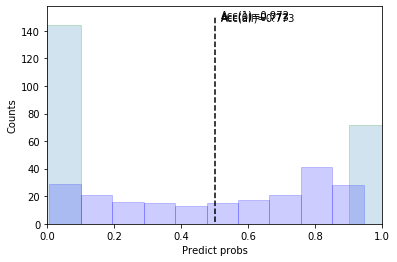

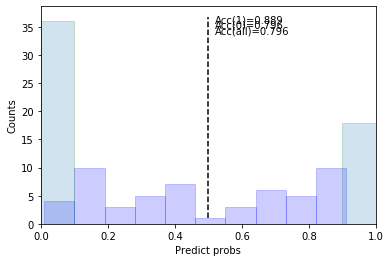

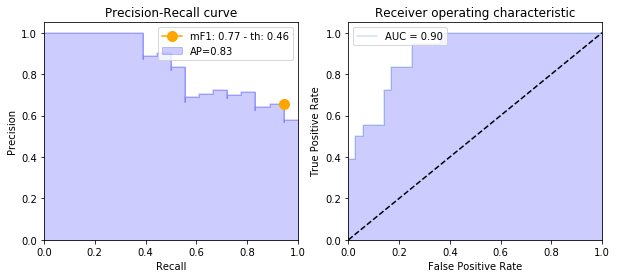

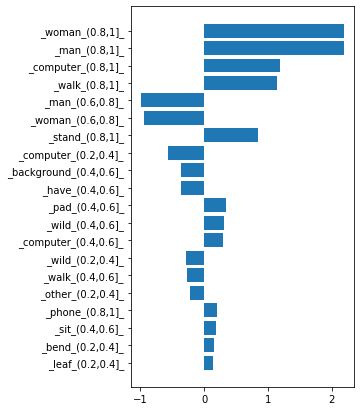

In [16]:
clf = train_classifier(pipeline.train_set, class_weight={1: 1, 0: 0.3}, C=1)
evaluate(clf, pipeline)

In [ ]:
class Predictor:
    def __init__(self):
        pass
    
    def __call__(self):
        

In [401]:
from collections import Counter
print(len(layerbase.layer_vocab_))
c = Counter(layerbase.layer_vocab_)
for layer, count in c.most_common():
    if count <= 1: break
    print(ravel(layer.entities_), count)
"""
layer keywords
then fetch these contain the tokens in the transformed(to keyword) description

how?
for each keyword, fetch a layer?
"""

82


'\nlayer keywords\nthen fetch these contain the tokens in the transformed(to keyword) description\n\nhow?\nfor each keyword, fetch a layer?\n'

### generator

In [8]:
import spacy
# from spacy.pipeline import Tagger
nlp = spacy.load("en_core_web_sm")
# tagger = Tagger(nlp.vocab)
# tagger = nlp.create_pipe("tagger")
# tagger(
doc = nlp(u'A joyful man plays computer frequently and sits on the ground')
for token in doc:
    print(token.i, token.text, token.tag_, token.is_stop)


0 A DT True
1 joyful JJ False
2 man NN False
3 plays VBZ False
4 computer NN False
5 frequently RB False
6 and CC True
7 sits VBZ False
8 on IN True
9 the DT True
10 ground NN False


In [10]:
token.is_space

False

In [72]:
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
token = nlp('ducks')
lemmas = lemmatizer(u"ducks", u"adjective")
# assert lemmas == [u"duck"]
type(token)

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'lower'

In [134]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(u'A man plays computer and hits the ground. A woman is waving.')
for token in doc:
    print("{2}({3}-{6}, {0}:{1}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))

det(man-2, A:DT-1)
nsubj(plays-3, man:NN-2)
ROOT(plays-3, plays:VBZ-3)
dobj(plays-3, computer:NN-4)
cc(plays-3, and:CC-5)
conj(plays-3, hits:VBZ-6)
det(ground-8, the:DT-7)
dobj(hits-6, ground:NN-8)
punct(plays-3, .:.-9)
det(woman-11, A:DT-10)
nsubj(waving-13, woman:NN-11)
aux(waving-13, is:VBZ-12)
ROOT(waving-13, waving:VBG-13)
punct(waving-13, .:.-14)


In [409]:
# doc = nlp(u'A man and a man play computer on the ground. A woman is waving.')
# doc = nlp(u'There is a tree and some plants in the park')
doc = nlp(u'A man is lying on the sofa watching the movie') # xcomp
for token in doc:
    print("{2}({3}-{6}, {0}:{1}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))

det(man-2, A:DT-1)
nsubj(lying-4, man:NN-2)
aux(lying-4, is:VBZ-3)
ROOT(lying-4, lying:VBG-4)
prep(lying-4, on:IN-5)
det(sofa-7, the:DT-6)
pobj(on-5, sofa:NN-7)
advcl(lying-4, watching:VBG-8)
det(movie-10, the:DT-9)
dobj(watching-8, movie:NN-10)


In [275]:
list(list(list(doc.sents)[0].root.children)[1].children)

[a, and, plants, in]

In [285]:
if list(doc.sents)[0].root.children:
    print(1)

1


In [152]:
list(list(doc[9].children)[0].children)

[ground]

In [142]:
[list(sent.root.children) for sent in doc.sents]

[[man, are, computer, and, sits, .], [woman, is, .]]

In [154]:
## entities detection
list(doc.ents)
## sentences
print(list(doc.sents))
print([s.root.text for s in doc.sents])


## sentencizer # this would be sufficient for current ravel similarity
doc = nlp(u'A man and a man are playing computer and sitting on the ground. A woman is waving.')
keywords = []
for s in doc.sents:
    keywords.append([t.lemma_ for t in s if t.pos_ in ['VERB', 'NOUN'] and not t.is_stop])
print(keywords)

[A man and a man are playing computer and sitting on the ground., A woman is waving.]
['playing', 'waving']
[['man', 'man', 'play', 'computer', 'sit', 'ground'], ['woman', 'wave']]


In [160]:
re.match(r'\w+obj','dobj')

<re.Match object; span=(0, 4), match='dobj'>

In [297]:
def recur_search_children(root, dep_r=r'\w*obj',
                                pos_r=r'.*',
                                skip_conj=True):
    objs = []
    for t in root.children:
        if skip_conj:
            if t.dep_ == 'conj':
                continue
        if re.match(dep_r, t.dep_) and re.match(pos_r, t.pos_):
            objs.append(t)
        if t.children:
            objs.extend(recur_search_children(t, dep_r=dep_r,
                                                 pos_r=pos_r,
                                                 skip_conj=skip_conj))
    return objs

def rect_lemma(t):
    if t.is_stop:
        return 'have'
    return t.lemma_

def incre_name(s, dic):
    count = 0
    for k in dic:
        sub = re.sub(r'\w+(\d+)','', k)
        if re.match(r'%s\d*' % sub, s):
            count += 1
    if count > 0:
        return '%s%i' % (s, count)
    return s
    
def parse(doc):
    list_nested = []
    for s in doc.sents:
        nested_ = defaultdict(lambda: defaultdict(set))
        # root verb
        subjs = recur_search_children(s.root, dep_r=r'\w*subj')
        if not subjs:
            subj_lemma = ''
        elif len(subjs) == 1:
            subj_lemma = subjs[0].lemma_
        else:
            raise ValueError
        nested_[subj_lemma][rect_lemma(s.root)] = set()
        
        objs = recur_search_children(s.root,
                                     dep_r=r'\w*(?=obj|attr)',
                                     skip_conj=False)
        for obj in objs:
            nested_[subj_lemma][rect_lemma(s.root)].add(obj.lemma_)
        
        # conj verbs
        conj_acts = recur_search_children(s.root,
                                          dep_r=r'\w*conj',
                                          pos_r=r'VERB',
                                          skip_conj=False)
        for act in conj_acts:
            
            nested_[subj_lemma][rect_lemma(act)] = set()
            objs = recur_search_children(act,
                                         dep_r=r'\w*(?=obj|attr)',
                                         skip_conj=False)            
            for obj in objs:
                nested_[subj_lemma][rect_lemma(act)].add(obj.lemma_) 

        # conj subjs
        if subjs:
            conj_subjs = recur_search_children(subjs[0],
                                               dep_r=r'\w*conj',
                                               pos_r=r'NOUN',
                                               skip_conj=False)

            for conj_subj in conj_subjs:
                conj_subj_lemma = incre_name(conj_subj.lemma_,
                                             nested_)
                nested_[conj_subj_lemma] = nested_[subj_lemma]
        
        list_nested.append(nested_)
#     for subj in doc:
#         if subj.dep_ == 'nsubj':
#             assert(subj.head.pos_ == 'VERB')
#             act = subj.head
#             nested_entities[subj.lemma_][act.lemma_] = set()
#             for token in doc:
#                 if token.head == act and token.dep_ == 'dobj':
#                     nested_entities[subj.lemma_][act.lemma_].add(token.lemma_)
#                 if token.head == act and token.dep_ =='conj':
#                     nested_entities[subj.lemma_][token.lemma_] = set()
#                     for t in doc:
#                         if t.head == token and t.dep_ == 'dobj':
#                             nested_entities[subj.lemma_][token.lemma_].add(t.lemma_)
#                 if token.head == act and token.dep_ == 'prep':
#                     for t in doc:
#                         if t.head == token and t.dep_ == 'pobj':
#                             nested_entities[subj.lemma_]['have'].add(t.lemma_)
# #             for token in doc:
# #                 if token.
    return list_nested

In [411]:
# if conj subj: copy at the last

In [401]:
a = {'a':1}
a.deepcopy()

AttributeError: 'dict' object has no attribute 'deepcopy'

In [375]:
l = list(doc)
l.remove(doc[1])
l.remove(doc[4])
l

[A,
 and,
 a,
 are,
 playing,
 computer,
 on,
 the,
 ground,
 in,
 the,
 park,
 .,
 A,
 woman,
 is,
 waving,
 .,
 A,
 man,
 is,
 playing,
 .,
 There,
 are,
 some,
 trees,
 and,
 plants,
 in,
 the,
 park,
 .]

In [345]:
l = remove_stop(doc)
print(list_tokens[0])
l.remove(list_tokens[0])
l

man


[man,
 playing,
 computer,
 ground,
 park,
 woman,
 waving,
 man,
 playing,
 trees,
 plants,
 park]

In [328]:
re.sub(r'(?<=\w)\d+','', 'man1')

'man'

In [324]:
re.match(r'man\d*', 'park')

In [73]:
doc.to_json()

{'text': 'A man plays computer and sits on the ground. A woman is waving.',
 'ents': [],
 'sents': [{'start': 0, 'end': 44}, {'start': 45, 'end': 63}],
 'tokens': [{'id': 0,
   'start': 0,
   'end': 1,
   'pos': 'DET',
   'tag': 'DT',
   'dep': 'det',
   'head': 1},
  {'id': 1,
   'start': 2,
   'end': 5,
   'pos': 'NOUN',
   'tag': 'NN',
   'dep': 'nsubj',
   'head': 2},
  {'id': 2,
   'start': 6,
   'end': 11,
   'pos': 'VERB',
   'tag': 'VBZ',
   'dep': 'ROOT',
   'head': 2},
  {'id': 3,
   'start': 12,
   'end': 20,
   'pos': 'NOUN',
   'tag': 'NN',
   'dep': 'dobj',
   'head': 2},
  {'id': 4,
   'start': 21,
   'end': 24,
   'pos': 'CCONJ',
   'tag': 'CC',
   'dep': 'cc',
   'head': 2},
  {'id': 5,
   'start': 25,
   'end': 29,
   'pos': 'VERB',
   'tag': 'VBZ',
   'dep': 'conj',
   'head': 2},
  {'id': 6,
   'start': 30,
   'end': 32,
   'pos': 'ADP',
   'tag': 'IN',
   'dep': 'prep',
   'head': 5},
  {'id': 7,
   'start': 33,
   'end': 36,
   'pos': 'DET',
   'tag': 'DT',
   'de

In [62]:
tuples = []
from collections import Counter
for text, c in Counter([token.head.text for token in doc]).most_common():
    print(text)
    tuples.append([token.text for token in doc if token.head.text == text and token.dep_ in ['nsubj', 'ROOT', 'dobj', 'conj']])
tuples

plays
waving
man
sits
ground
on
woman


[['man', 'plays', 'computer'], ['woman', 'waving'], [], [], [], [], []]

In [86]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

A a DET DT det
man man NOUN NN nsubj
plays play VERB VBZ ROOT
computer computer NOUN NN dobj
and and CCONJ CC cc
sits sit VERB VBZ conj
on on ADP IN prep
the the DET DT det
ground ground NOUN NN pobj
. . PUNCT . punct
A a DET DT det
woman woman NOUN NN nsubj
is be VERB VBZ aux
waving wave VERB VBG ROOT
. . PUNCT . punct


In [27]:
def generator(description):
    """
    Given a description, propose several layers for selection
    """
    assert(isinstance(description, Description))
    

In [16]:
LayerName('#man(have[pant,woof],do[shit])').nested_entities_ == LayerName('#man(do[shit],have[woof,pant])').nested_entities_

True

In [21]:
LayerName('#man(have[pant,woof],do[shit])').nested_entities_.items()

dict_items([('man', {'have': {'woof', 'pant'}, 'do': {'shit'}})])

In [77]:
a = set()
a.add(1)
a
a.union({1,2})
a

{1}

In [22]:
((1,),(2,))

((1,), (2,))